In [1]:
import warnings
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
from radar.util import xy2ll
from datetime import datetime
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
warnings.simplefilter("ignore")
%matplotlib notebook

## 数据处理

In [2]:
root = './meso_learning.xlsx'
# 龙卷中气旋数据
tor_dat = pd.read_excel(root, sheet_name='T', parse_dates={'Time' : [0, 1, 2]},
                     date_parser=datetime, index_col=0).dropna()
tor_dat['hour'] = tor_dat['hour'] + 8  # UTC to BJT
tor_dat.loc[:, ['lon','lat']] = 0.
# 非龙卷中气旋数据
non_tor_dat = pd.read_excel(root, sheet_name='NT', parse_dates={'Time' : [0, 1, 2]},
                     date_parser=datetime, index_col=0).dropna()
non_tor_dat['hour'] = non_tor_dat['hour'] + 8
non_tor_dat.loc[:, ['lon','lat']] = 0.

In [3]:
# 匹配经纬度
radar_site = {'513' : [120.976, 32.076], '515' : [120.201, 33.431], '516' : [117.152, 34.293],
              '517' : [118.826, 33.243], '518' : [119.294, 34.651], '523' : [119.994, 32.557], 
              '250' : [118.698, 32.191]}
for k, v in radar_site.items():
    tor_dat.loc[tor_dat['radarID'].values == int(k), 'lon':'lat'] = v[0], v[1]
    non_tor_dat.loc[non_tor_dat['radarID'].values == int(k), 'lon':'lat'] = v[0], v[1]

In [4]:
# 训练误差数据读取及处理
predict_dat = pd.read_csv('./predict_problem.csv', index_col=0)
hour,mint = [], []
for time in predict_dat['Time'].values:
    h, m = str.split(time,':')
    hour.append(str(int(h) + 8))
    mint.append(str(int(m)))        
predict_dat['hour'], predict_dat['min'] = hour, mint 

## 个例特征分布

### 个例地理位置统计与分布

In [5]:
# 计算样本资料分布的经纬度信息
def compute_lon_lat(data):
    stns = np.unique(data['radarID'])
    lons = list(np.empty((len(stns), 1)))
    lats = list(np.empty((len(stns), 1)))
    for idx, stn in enumerate(stns):
        rng = data.loc[data['radarID'] == stn, 'RNG(KM)'].values
        az = data.loc[data['radarID'] == stn, 'AZ(DEG)'].values
        xx = rng * np.cos(np.deg2rad(90. - az))
        yy = rng * np.sin(np.deg2rad(90. - az))
        lon0 = data.loc[data['radarID'] == stn, 'lon'].values
        lat0 = data.loc[data['radarID'] == stn, 'lat'].values
        lons[idx], lats[idx] = xy2ll(xx, yy, lon0, lat0)
    result = pd.DataFrame({'stn': stns, 'lon': lons, 'lat': lats})
    return result

In [6]:
# 绘制样本资料的空间分布
def meso_distribution(ax, t_lon_lat, nt_lon_lat, date):
    crs = ccrs.LambertConformal(central_longitude=121.5, central_latitude=31.5)
    ax.set_extent([-1000e3, 400.e3, -300e3, 600.e3], crs=crs)
    m = ['o', "^"]
    for idx, stn in enumerate(np.unique(t_lon_lat['stn'])):
        ax.scatter(t_lon_lat.loc[t_lon_lat['stn'] == stn, 'lon'].values[0], 
                   t_lon_lat.loc[t_lon_lat['stn'] == stn, 'lat'].values[0], 
                   marker=m[idx], s=10, color='C6', label=str(stn) +'_' + 't_meso', transform=ccrs.PlateCarree())
        ax.scatter(nt_lon_lat.loc[nt_lon_lat['stn'] == stn, 'lon'].values[0], 
                   nt_lon_lat.loc[nt_lon_lat['stn'] == stn, 'lat'].values[0], 
                   marker=m[idx], s=10, color='C8', label=str(stn) +'_' + 'nt_meso', transform=ccrs.PlateCarree())
    ax.legend(loc='upper left')

### 个例切变特征统计与分布

In [7]:
# 中气旋样本个例切变强度以及最大切变所在高度统计
def shear_static(data, date):
    y, m, d = date.split('-')
    stns = np.unique(data['radarID'])
    shears = list(np.empty((len(stns), 1)))
    shear_heights = list(np.empty((len(stns), 1)))
    times = list(np.empty((len(stns), 1)))
    for idx, stn in enumerate(np.unique(data['radarID'])):
        if data['M_SHEAR'].size >= 2:
            shears[idx] = data.loc[data['radarID'] == stn, 'M_SHEAR'].values
            shear_heights[idx] = data.loc[data['radarID'] == stn, 'M_HGT(KM)'].values
            time = pd.DataFrame({'year' : y, 'month' : m, 'day' : d, 'h' : data.loc[data['radarID'] == stn, 'hour'].values, 
                                 'm' : data.loc[data['radarID'] == stn, 'min'].values})
            times[idx] = pd.to_datetime(time)
        else:
            shears[idx], shear_heights[idx] = data['M_SHEAR'], data['M_HGT(KM)']
            times[idx] = datetime(int(y), int(m), int(d), int(data['hour']), int(data['min']))
    return times, shears, shear_heights, stns

In [8]:
# 绘制中气旋样本切变强度变化
def shear_paint(ax, date, tor_shears, non_tor_shears, pre_shear, vortex):
    ls = ['-', '--']
    for i in range(len(tor_shears[0])):
        # 龙卷样本个例
        ax.plot(tor_shears[0][i], tor_shears[1][i], marker='o', markersize=2.5, color='r', linewidth=1.5, 
                linestyle=ls[i], label=tor_shears[2][i])
        # 非龙卷样本个例
        ax.plot(non_tor_shears[0][i], non_tor_shears[1][i], marker='o', markersize=2.5, color='gray', 
                linewidth=1.5, linestyle=ls[i], label=non_tor_shears[2][i])
    if pre_shear[0] is not None:
        for j in range(len(pre_shear[0])):
            # 标记龙卷误判个例样本
            ax.scatter(pre_shear[0][j], pre_shear[1][j], marker="D", s=20, color='k')
    ax.tick_params(axis='both', labelsize=9)
    ax.legend(loc='upper left')
    ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))
    ax.axvline(vortex, color='b')
    ax.set_ylabel('Meso Shear (m/s)', fontsize=10)
    ax.grid(color='#CCCCCC', alpha=0.5)
    ax.set_title(date, fontsize=10)

In [9]:
# 绘制中气旋样本最大切变高度变化
def shear_heights_paint(ax, date, t_shear_hts_static, nt_shear_hts_static, vortex):
    ls = ['-', '--']
    for i in range(len(t_shear_hts_static[0])):
        ax.plot(t_shear_hts_static[0][i], t_shear_hts_static[1][i], marker='o', markersize=2.5, color='r', 
                linewidth=1.5, linestyle=ls[i], label=t_shear_hts_static[2][i])
        ax.plot(nt_shear_hts_static[0][i], nt_shear_hts_static[1][i], marker='o', markersize=2.5, color='gray', 
                linewidth=1.5, linestyle=ls[i], label=nt_shear_hts_static[2][i])
        ax.tick_params(axis='both', labelsize=9)
    ax.legend(loc='upper left')
    ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))
    ax.axvline(vortex, color='b')
    ax.set_xlabel('Times (HH:MM)', fontsize=10)
    ax.set_ylabel('Meso Shear Height (km)', fontsize=10)
    ax.grid(color='#CCCCCC', alpha=0.5)

In [10]:
def paint(dis_static, date, t_shear_static, nt_shear_static, pre_shear_static,
          t_shear_hts_static, nt_shear_hts_static, vortex_time):
    fg = plt.figure(figsize=(7.5, 7))
    crs = ccrs.LambertConformal(central_longitude=121.5, central_latitude=31.5)
#     ax1 = fg.add_subplot(3,1,1, projection=crs)  # 样本资料地理位置分布
    ax2 = fg.add_subplot(2,1,1)
    ax3 = fg.add_subplot(2,1,2)
#     meso_distribution(ax1, dis_static[0], dis_static[1], date)
    shear_paint(ax2, date, t_shear_static, nt_shear_static, pre_shear_static, vortex_time)
    shear_heights_paint(ax3, date, t_shear_hts_static, nt_shear_hts_static, vortex_time)
    fg.tight_layout()

In [21]:
def Sample_Set(date, tor_dat, non_dat, vor_time, pre_dat):
    tor_da = tor_dat.loc[date, :]
    non_da = non_dat.loc[date, :]
    if pre_dat is not None:
        pre_da = pre_dat.loc[date, :]
    else: pre_da = None
    # 中气旋分布
    t_ll = compute_lon_lat(tor_da)
    nt_ll = compute_lon_lat(non_da)
    # 切变分布
    t_times, t_shears, t_shear_hts, t_stns = shear_static(tor_da, date)
    nt_times, nt_shears, nt_shear_hts, nt_stns = shear_static(non_da, date)
    if pre_da is not None:
        pre_times, pre_shears, pre__shear_hts, pre_stns = shear_static(pre_da, date)
    else: pre_times, pre_shears, pre__shear_hts, pre_stns = None, None, None, None
    # 切变统计
    t_shear_static = [t_times, t_shears, t_stns]
    nt_shear_static = [nt_times, nt_shears, nt_stns]
    pre_shear_static = [pre_times, pre_shears, pre_stns]
    # 切变高度统计
    t_shear_hts_static = [t_times, t_shear_hts, t_stns]
    nt_shear_hts_static = [nt_times, nt_shear_hts, nt_stns]
    return [t_ll, nt_ll], t_shear_static, nt_shear_static, pre_shear_static, t_shear_hts_static, nt_shear_hts_static

### 2006年7月3日

In [22]:
date = '2006-07-03'
vortex_time = datetime(2006, 7, 3, 21, 51)
t_nt_ll, t_shear, nt_shear, pre_shear, t_shear_hts, nt_shear_hts = Sample_Set(date, tor_dat, non_tor_dat, 
                                                                              vortex_time, predict_dat)

<IPython.core.display.Javascript object>


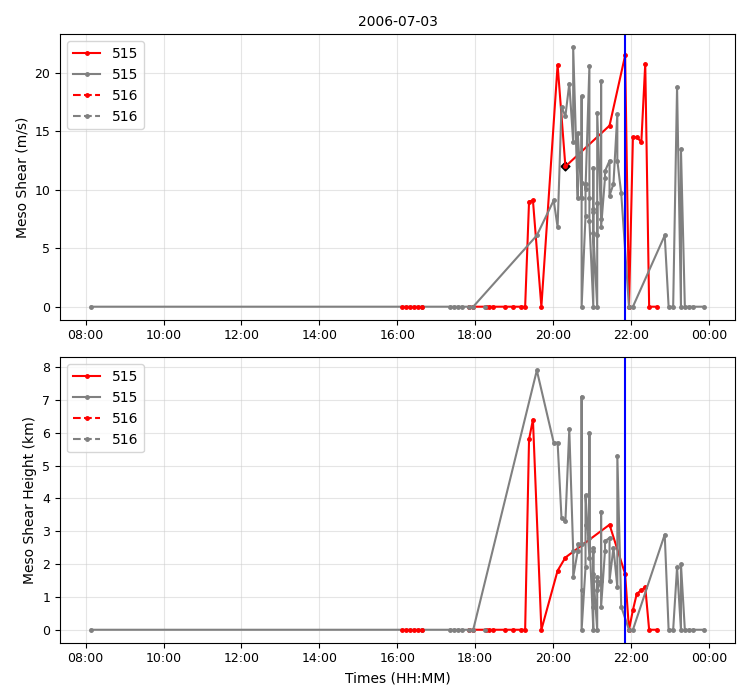

In [23]:
paint(t_nt_ll, date, t_shear, nt_shear, pre_shear, t_shear_hts, nt_shear_hts, vortex_time)

### 2007年7月3日

In [24]:
date = '2007-07-03'
vortex_time = datetime(2007, 7, 3, 16, 30)
t_nt_ll, t_shear, nt_shear, pre_shear, t_shear_hts, nt_shear_hts = Sample_Set(date, tor_dat, non_tor_dat, 
                                                                              vortex_time, predict_dat)

<IPython.core.display.Javascript object>


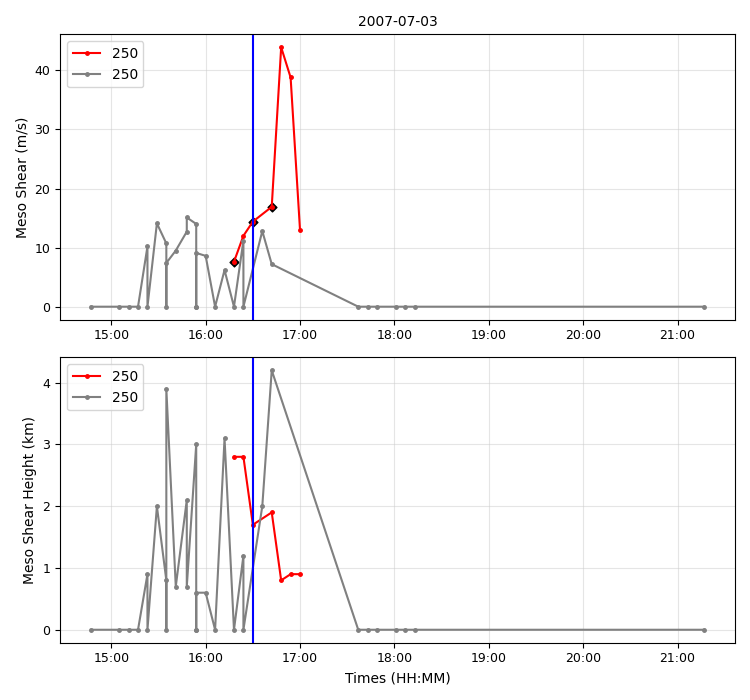

In [25]:
paint(t_nt_ll, date, t_shear, nt_shear, pre_shear, t_shear_hts, nt_shear_hts, vortex_time)

### 2008年7月4日

In [26]:
date = '2008-07-04'
vortex_time = datetime(2008, 7, 4, 19, 2)
t_nt_ll, t_shear, nt_shear, pre_shear, t_shear_hts, nt_shear_hts = Sample_Set(date, tor_dat, non_tor_dat, 
                                                                              vortex_time, predict_dat)

<IPython.core.display.Javascript object>


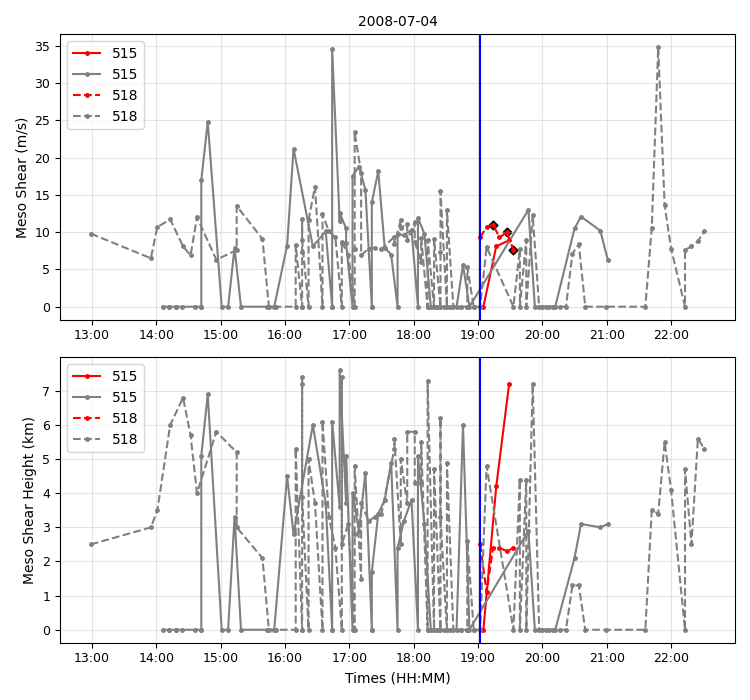

In [27]:
paint(t_nt_ll, date, t_shear, nt_shear, pre_shear, t_shear_hts, nt_shear_hts, vortex_time)

### 2010年7月17日

In [29]:
date = '2010-07-17'
vortex_time = datetime(2010, 7, 17, 19, 30)
t_nt_ll, t_shear, nt_shear, pre_shear, t_shear_hts, nt_shear_hts = Sample_Set(date, tor_dat, non_tor_dat, 
                                                                               vortex_time, None)

<IPython.core.display.Javascript object>


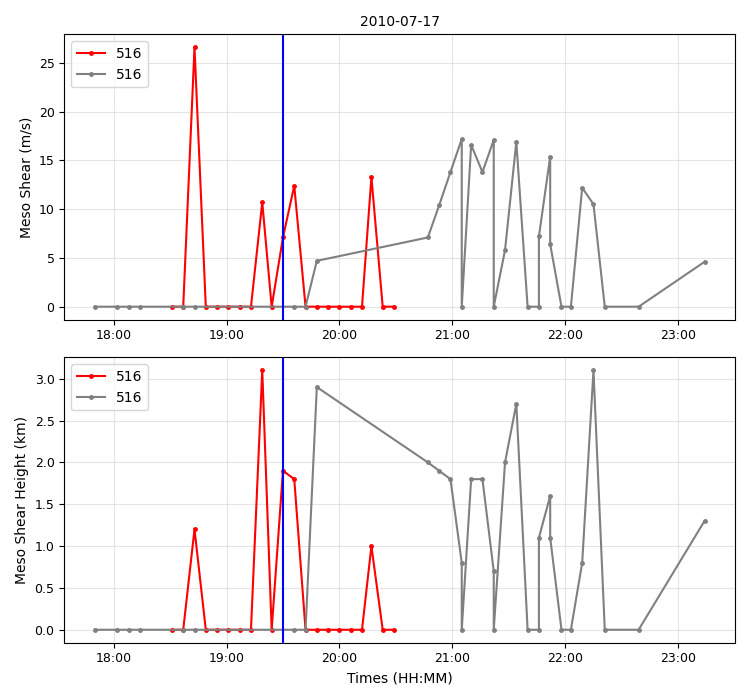

In [30]:
paint(t_nt_ll, date, t_shear, nt_shear, pre_shear, t_shear_hts, nt_shear_hts, vortex_time)

### 2011年7月13日

In [31]:
date = '2011-07-13'
vortex_time = datetime(2011, 7, 13, 17, 30)
t_nt_ll, t_shear, nt_shear, pre_shear, t_shear_hts, nt_shear_hts = Sample_Set(date, tor_dat, non_tor_dat, 
                                                                              vortex_time, predict_dat)

<IPython.core.display.Javascript object>


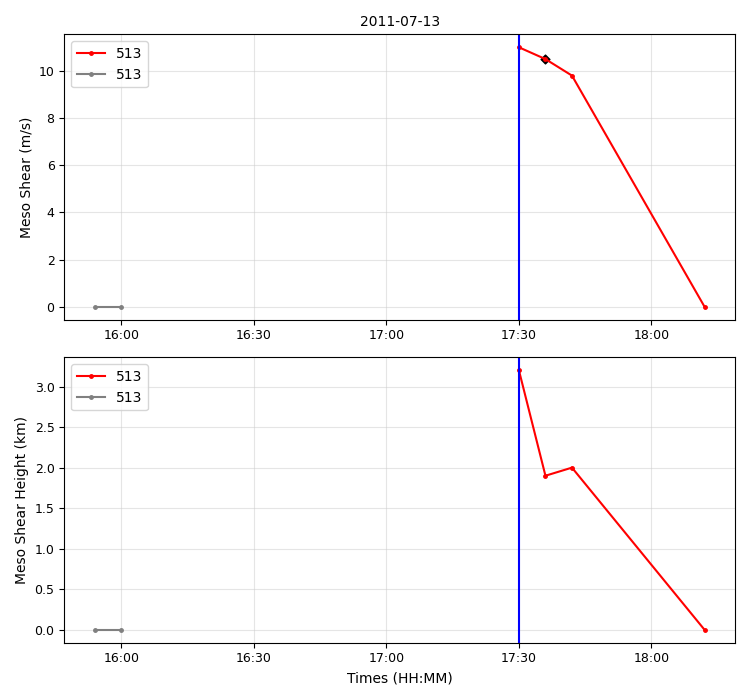

In [32]:
paint(t_nt_ll, date, t_shear, nt_shear, pre_shear, t_shear_hts, nt_shear_hts, vortex_time)

### 2016年6月23日

In [33]:
date = '2016-06-23'
vortex_time = datetime(2016, 6, 23, 13, 45)
t_nt_ll, t_shear, nt_shear, pre_shear, t_shear_hts, nt_shear_hts = Sample_Set(date, tor_dat, non_tor_dat, 
                                                                              vortex_time, predict_dat)

<IPython.core.display.Javascript object>


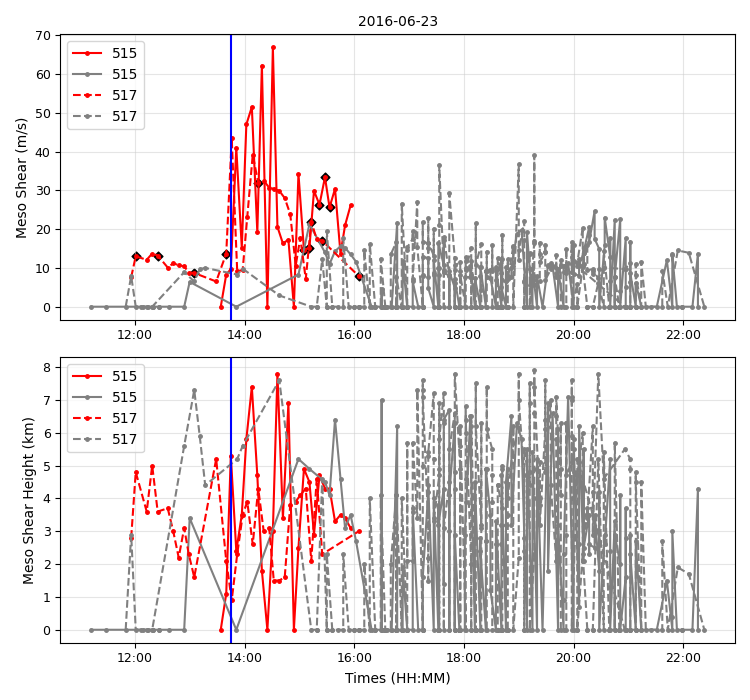

In [34]:
paint(t_nt_ll, date, t_shear, nt_shear, pre_shear, t_shear_hts, nt_shear_hts, vortex_time)

### 2017年7月2日

In [36]:
date = '2017-07-02'
vortex_time = datetime(2017, 7, 2, 10, 56)
t_nt_ll, t_shear, nt_shear, pre_shear, t_shear_hts, nt_shear_hts = Sample_Set(date, tor_dat, non_tor_dat, 
                                                                              vortex_time, None)

<IPython.core.display.Javascript object>


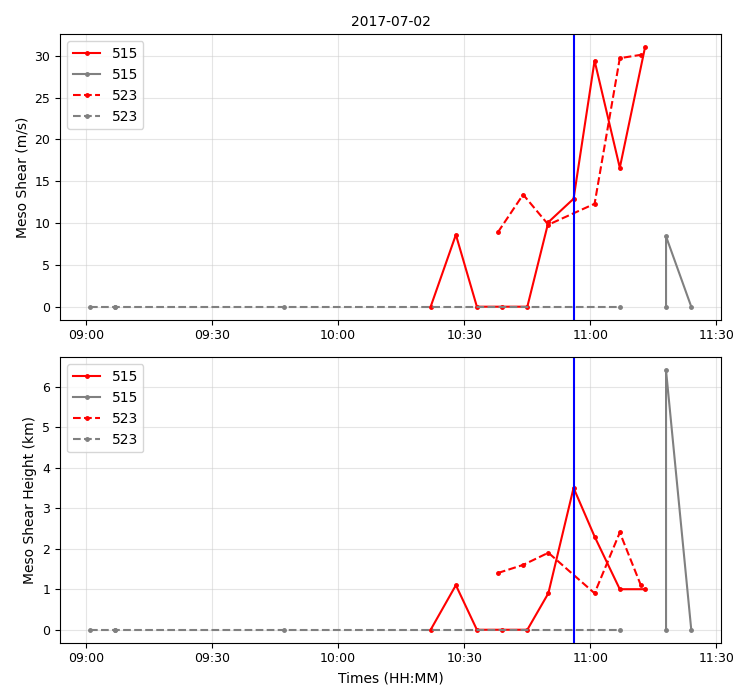

In [37]:
paint(t_nt_ll, date, t_shear, nt_shear, pre_shear, t_shear_hts, nt_shear_hts, vortex_time)